In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from joblib import Parallel, delayed


In [2]:
save_file = 'example_bimaxwellian_128x128.nc'

In [3]:
mass = 3.343e-27
kev_to_J = 1000*1.6022e-19
T_perp = .4*kev_to_J # keV
T_par = 1*kev_to_J # keV
T_shift = 80*kev_to_J

v_t_perp = np.sqrt(2*T_perp/mass)
v_t_par = np.sqrt(2*T_par/mass)
density = 1e15 # per m^3

T_bulk =  5*kev_to_J # keV
vt_bulk = np.sqrt(2*T_bulk/mass)
bulk_density = 5.9e19

vshift = np.sqrt(T_shift/mass) # factor of 2 gone due to double shift math 

def f_2d(vperp, vpar):
    factor = density / (np.pi**(3/2)*v_t_par*v_t_perp**2)
    return factor * np.exp(-vpar**2/v_t_par**2 -vperp**2/v_t_perp**2)

def f_2d_shift(vperp, vpar):
    factor = density / (np.pi**(3/2)*v_t_par*v_t_perp**2)
    return factor * np.exp(-(vpar-vshift)**2/v_t_par**2 -(vperp-vshift)**2/v_t_perp**2)

# bimaxwellian with thermal bulk 
def f_2d_bulk_and_tail(vperp, vpar, den_fac, non_maxwell_denfac, shift=False):
    factor1 = bulk_density / (np.pi**(3/2)*vt_bulk**3)

    if shift:
        return non_maxwell_denfac*f_2d_shift(vperp, vpar) + den_fac*factor1*np.exp(-vpar**2/vt_bulk**2 -vperp**2/vt_bulk**2)
    else:
        return non_maxwell_denfac*f_2d(vperp, vpar) + den_fac*factor1*np.exp(-vpar**2/vt_bulk**2 -vperp**2/vt_bulk**2)
    
def denfac_function(R, Z, nedge_ratio, R0, Rmin, alpha=0.4):
    a = R0 - Rmin
    x = R - R0
    y = Z
    r = np.sqrt(x**2 + y**2)
    if r <= a:
        return (1 - (r/a)**2)**alpha + nedge_ratio
    else:
        return nedge_ratio

num_R = 128
num_Z = 128
num_vperp = 65
num_vpar = 129

vmax = np.sqrt(2*500*kev_to_J/mass)
print(vmax/3e8)
print(f'vmax: {vmax*100/3e8}% c')


vperp_array = np.linspace(0, vmax, num_vperp)
vpar_array = np.linspace(-vmax, vmax, num_vpar)
r_array = np.linspace(1.05, 2.25, num_R)
z_array = np.linspace(-1, 1, num_Z)

f_mat = np.zeros((r_array.shape[0], z_array.shape[0], vperp_array.shape[0], vpar_array.shape[0]))
denfac_mat = np.zeros((r_array.shape[0], z_array.shape[0]))
non_maxwell_fac_mat = np.zeros((r_array.shape[0], z_array.shape[0]))

# load up array. f is independent of r, z
        # right now no rz dependence. 
        #f = f_2d(vperp, vpar)
# for ir in range(r_array.shape[0]):
#     for iz in range(z_array.shape[0]):
#         R = r_array[ir]
#         Z = z_array[iz]
#         denfac = denfac_function(R, Z, nedge_ratio=.00008, R0=1.65, Rmin=1.05, alpha=0.4)
#         denfac_mat[ir, iz] = denfac
#         non_max_fac = 1
#         if denfac <=1:
#             non_max_fac = denfac
#         non_maxwell_fac_mat[ir,iz] = non_max_fac
#         for ivper in range(vperp_array.shape[0]):
#             for ivpar in range(vpar_array.shape[0]):
#                 vperp = vperp_array[ivper]
#                 vpar = vpar_array[ivpar]
#                 f = f_2d_bulk_and_tail(vperp, vpar, den_fac=denfac, non_maxwell_denfac=non_max_fac, shift=True)
#                 f_mat[ir, iz, ivper, ivpar] = f

# f_mat = np.zeros((vpar_array.shape[0], vperp_array.shape[0], z_array.shape[0], r_array.shape[0]))

# # load up array. f is independent of r, z
# for ivper in range(vperp_array.shape[0]):
#     for ivpar in range(vpar_array.shape[0]):
#         vperp = vperp_array[ivper]
#         vpar = vpar_array[ivpar]
#         f = f_2d(vperp, vpar)
#         for ir in range(r_array.shape[0]):
#             for iz in range(z_array.shape[0]):
#                 f_mat[ivpar, ivper,iz, ir] = f

0.02307644582352994
vmax: 2.307644582352994% c


In [182]:

def compute_rz(ir, iz, r_array, z_array, vperp_array, vpar_array):
    R = r_array[ir]
    Z = z_array[iz]
    # print(f"ir={ir}, iz={iz}, R={R:.3f}, Z={Z:.3f}")  # add this line
    denfac = denfac_function(R, Z, nedge_ratio=.00008, R0=1.65, Rmin=1.05, alpha=0.4)
    non_max_fac = denfac**10 if denfac <= 1 else 1

    f_local = np.zeros((len(vperp_array), len(vpar_array)))
    for ivper, vperp in enumerate(vperp_array):
        for ivpar, vpar in enumerate(vpar_array):
            f_local[ivper, ivpar] = f_2d_bulk_and_tail(vperp, vpar,
                                                       den_fac=denfac,
                                                       non_maxwell_denfac=non_max_fac,
                                                       shift=True)
    return ir, iz, denfac, non_max_fac, f_local

results = Parallel(n_jobs=-1)(  # -1 = use all cores
    delayed(compute_rz)(ir, iz, r_array, z_array, vperp_array, vpar_array)
    for ir in range(len(r_array))
    for iz in range(len(z_array))
)

# reconstruct arrays
f_mat = np.zeros((len(r_array), len(z_array), len(vperp_array), len(vpar_array)))
denfac_mat = np.zeros((len(r_array), len(z_array)))
non_maxwell_fac_mat = np.zeros((len(r_array), len(z_array)))

for ir, iz, denfac, non_max_fac, f_local in results:
    denfac_mat[ir, iz] = denfac
    # print(f'min f_local: {np.min(f_local)}')
    # print(f'max f_local: {np.max(f_local)}')
    non_maxwell_fac_mat[ir, iz] = non_max_fac
    f_mat[ir, iz,:,:] = f_local

In [183]:
print(np.max(f_mat))

31.933809367957352


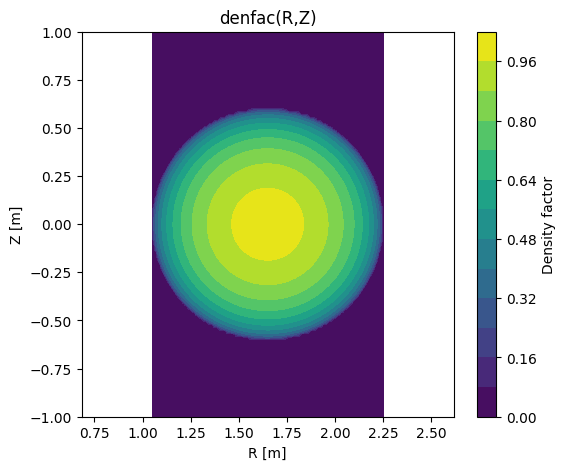

In [184]:
Rmat, Zmat = np.meshgrid(r_array, z_array)
plt.figure(figsize=(6,5))
cp = plt.contourf(Rmat, Zmat, denfac_mat.T, levels=15, cmap="viridis")
plt.colorbar(cp, label="Density factor")
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
plt.title("denfac(R,Z)")
plt.axis('equal')
plt.show()


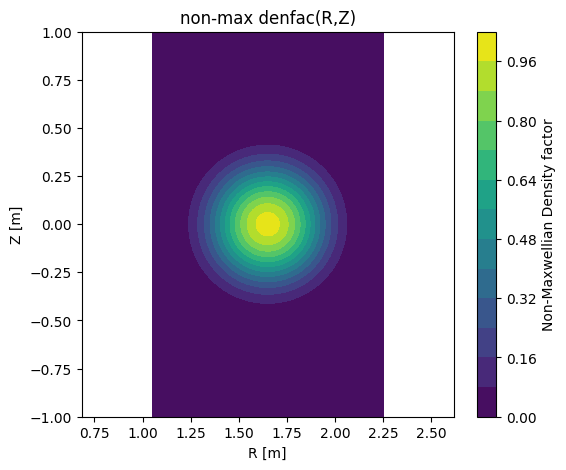

In [185]:
Rmat, Zmat = np.meshgrid(r_array, z_array)
plt.figure(figsize=(6,5))
cp = plt.contourf(Rmat, Zmat, non_maxwell_fac_mat.T, levels=15, cmap="viridis")
plt.colorbar(cp, label="Non-Maxwellian Density factor")
plt.xlabel("R [m]")
plt.ylabel("Z [m]")
plt.title("non-max denfac(R,Z)")
plt.axis('equal')
plt.show()

In [186]:
# test by integrating

def integrate_density(f_slice, vperp, vpar):
    """
    f_slice: 2D array f(vperp, vpar) at fixed (r,z)
    vperp, vpar: 1D arrays of grid points
    """
    # Compute spacings
    dvper = np.diff(vperp)
    dvpar = np.diff(vpar)

    # Meshgrid for midpoints
    vper_mid = 0.5 * (vperp[:-1] + vperp[1:])
    vpar_mid = 0.5 * (vpar[:-1] + vpar[1:])

    VPER, VPAR = np.meshgrid(vper_mid, vpar_mid, indexing="ij")

    # Take f at cell centers
    f_mid = 0.25 * (f_slice[:-1,:-1] + f_slice[1:,:-1] +
                    f_slice[:-1,1:] + f_slice[1:,1:])

    # Cell area
    dVper, dVpar = np.meshgrid(dvper, dvpar, indexing="ij")

    # Integral with 2π v_perp Jacobian
    n = np.sum(f_mid * (2*np.pi*VPER) * dVper * dVpar)
    return n

# Example usage
iR, iZ = 16, 64  # pick one r,z index
f_slice = f_mat[iR, iZ, :, :]  # shape (num_vper, num_vpar)
print(f'min fslice: {np.min(f_slice)}')
print(f'max fslice: {np.max(f_slice)}')
n_val = integrate_density(f_slice, vperp_array, vpar_array)
print("Integrated density =", n_val/1e19)




min fslice: 3.1834555853873763e-86
max fslice: 23.003566552001928
Integrated density = 4.284693067024516


In [159]:
# #f_fortran = np.asfortranarray(f_mat.astype(np.float32))
# with netCDF4.Dataset(save_file, "w", format="NETCDF4") as nc:

#     # create dimensions 
#     nc.createDimension("R_binCenters", num_R)
#     nc.createDimension("z_binCenters", num_Z)
#     nc.createDimension("vPer_binCenters", num_vperp)
#     nc.createDimension("vPar_binCenters", num_vpar)

#     # Then create coordinate variables with matching dimensions
#     r_var     = nc.createVariable("R_binCenters", "f8", ("R_binCenters",))
#     z_var     = nc.createVariable("z_binCenters", "f8", ("z_binCenters",))
#     vperp_var = nc.createVariable("vPer_binCenters", "f8", ("vPer_binCenters",))
#     vpar_var  = nc.createVariable("vPar_binCenters", "f8", ("vPar_binCenters",))

#     # And the 4D f array
#     f_var = nc.createVariable("f_rzvv", "f4", ("R_binCenters","z_binCenters","vPer_binCenters","vPar_binCenters"))

#     # Write data
#     r_var[:]      = r_array
#     z_var[:]      = z_array
#     vperp_var[:]  = vperp_array
#     vpar_var[:]   = vpar_array
#     f_var[:,:,:,:] = f_mat.astype(np.float32)

#     # Optional: add metadata
#     nc.title = "Example bimaxwellian distribution function"

# print(f'File saved to {save_file}\n')

In [187]:
from netCDF4 import Dataset

def write_f_rzvv_nc(filename, R_centers, Z_centers, vPer_centers, vPar_centers, f_rzvv):
    """
    Write f_rzvv to NetCDF in the same convention as p2f.

    Parameters
    ----------
    filename : str
        Output .nc filename
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D arrays
        Bin centers
    f_rzvv : ndarray, shape (nR, nZ, nVper, nVpar)
        Distribution function in Python order [R, Z, vPer, vPar]
    """

    # Sanity checks
    nR, nZ, nVper, nVpar = f_rzvv.shape
    assert len(R_centers) == nR
    assert len(Z_centers) == nZ
    assert len(vPer_centers) == nVper
    assert len(vPar_centers) == nVpar

    # Convert to Fortran order for NetCDF
    # Python (R,Z,vPer,vPar) -> NetCDF (vPar,vPer,Z,R)
    f_to_save = np.transpose(f_rzvv, (3, 2, 1, 0))

    with Dataset(filename, "w", format="NETCDF4") as nc:
        # Dimensions
        nc.createDimension("R_nBins", nR)
        nc.createDimension("z_nBins", nZ)
        nc.createDimension("vPer_nBins", nVper)
        nc.createDimension("vPar_nBins", nVpar)

        nc.createDimension("R_nBins_p1", nR+1)
        nc.createDimension("z_nBins_p1", nZ+1)
        nc.createDimension("vPer_nBins_p1", nVper+1)
        nc.createDimension("vPar_nBins_p1", nVpar+1)

        nc.createDimension("scalar", 1)

        # Variables
        fvar = nc.createVariable("f_rzvv", "f4",
                                 ("vPar_nBins", "vPer_nBins", "z_nBins", "R_nBins"))
        Rvar = nc.createVariable("R_binCenters", "f4", ("R_nBins",))
        Zvar = nc.createVariable("z_binCenters", "f4", ("z_nBins",))
        vPervar = nc.createVariable("vPer_binCenters", "f4", ("vPer_nBins",))
        vParvar = nc.createVariable("vPar_binCenters", "f4", ("vPar_nBins",))

        # Assign data
        fvar[:, :, :, :] = f_to_save
        Rvar[:] = R_centers
        Zvar[:] = Z_centers
        vPervar[:] = vPer_centers
        vParvar[:] = vPar_centers

        # Example scalar metadata
        nc.createVariable("nP", "i4", ("scalar",))[:] = [0]
        nc.createVariable("R_binSize", "f4", ("scalar",))[:] = [R_centers[1]-R_centers[0]]
        nc.createVariable("z_binSize", "f4", ("scalar",))[:] = [Z_centers[1]-Z_centers[0]]
        nc.createVariable("vPer_binSize", "f4", ("scalar",))[:] = [vPer_centers[1]-vPer_centers[0]]
        nc.createVariable("vPar_binSize", "f4", ("scalar",))[:] = [vPar_centers[1]-vPar_centers[0]]

        # Optional: edges
        nc.createVariable("R_binEdges", "f4", ("R_nBins_p1",))[:] = np.linspace(R_centers[0], R_centers[-1], nR+1)
        nc.createVariable("z_binEdges", "f4", ("z_nBins_p1",))[:] = np.linspace(Z_centers[0], Z_centers[-1], nZ+1)
        nc.createVariable("vPer_binEdges", "f4", ("vPer_nBins_p1",))[:] = np.linspace(vPer_centers[0], vPer_centers[-1], nVper+1)
        nc.createVariable("vPar_binEdges", "f4", ("vPar_nBins_p1",))[:] = np.linspace(vPar_centers[0], vPar_centers[-1], nVpar+1)

        # Metadata
        nc.title = "Python-generated test f_rzvv, stored in Fortran-compatible order"

    print(f"✅ Wrote {filename} with f_rzvv shape {f_rzvv.shape} (Python) → {f_to_save.shape} (NetCDF)")

# make a read function to read p2f file for f_rzvv

def read_f_rzvv_nc(filename):
    """
    Read f_rzvv from NetCDF (p2f convention) and return arrays in Python order:
        f_rzvv.shape = (nR, nZ, nVper, nVpar)

    Parameters
    ----------
    filename : str
        Path to .nc file

    Returns
    -------
    R_centers, Z_centers, vPer_centers, vPar_centers : 1D numpy arrays
    f_rzvv : 4D numpy array, shape (nR, nZ, nVper, nVpar)
    """
    with Dataset(filename, "r") as nc:
        R = nc.variables["R_binCenters"][:]
        Z = nc.variables["z_binCenters"][:]
        vPer = nc.variables["vPer_binCenters"][:]
        vPar = nc.variables["vPar_binCenters"][:]

        f_nc = nc.variables["f_rzvv"][:]  # stored as (vPar, vPer, Z, R)

    # Reorder to Python natural (R,Z,vPer,vPar)
    f_python = np.transpose(f_nc, (3, 2, 1, 0))

    return R, Z, vPer, vPar, f_python

In [188]:
# save the netcdf file 
write_f_rzvv_nc(filename=save_file, R_centers=r_array, Z_centers=z_array, vPer_centers=vperp_array, vPar_centers=vpar_array, f_rzvv=f_mat)

✅ Wrote example_bimaxwellian_128x128.nc with f_rzvv shape (128, 128, 65, 129) (Python) → (129, 65, 128, 128) (NetCDF)


In [162]:
# #f_fortran = np.asfortranarray(f_mat.astype(np.float32))
# with netCDF4.Dataset(save_file, "w", format="NETCDF4") as nc:

#     # create dimensions 
#     nc.createDimension("R_nBins", num_R)
#     nc.createDimension("z_nBins", num_Z)
#     nc.createDimension("vPer_nBins", num_vperp)
#     nc.createDimension("vPar_nBins", num_vpar)

#     # create coordinate variables
#     r_var     = nc.createVariable("R_binCenters", "f4", ("R_nBins",))
#     z_var     = nc.createVariable("z_binCenters", "f4", ("z_nBins",))
#     vperp_var = nc.createVariable("vPer_binCenters", "f4", ("vPer_nBins",))
#     vpar_var  = nc.createVariable("vPar_binCenters", "f4", ("vPar_nBins",))

#     # create 4D f variable with matching dimension names
#     f_var = nc.createVariable("f_rzvv", "f4", ("R_nBins", "z_nBins", "vPer_nBins", "vPar_nBins"))

#     # write coordinate data
#     r_var[:]      = r_array
#     z_var[:]      = z_array
#     vperp_var[:]  = vperp_array
#     vpar_var[:]   = vpar_array

#     # write f data
#     f_var[:,:,:,:] = f_mat

#     # metadata
#     nc.title = "Example bimaxwellian distribution function"
#     nc.sync()   # forces write to disk

Text(0, 0.5, 'vper [m/s]')

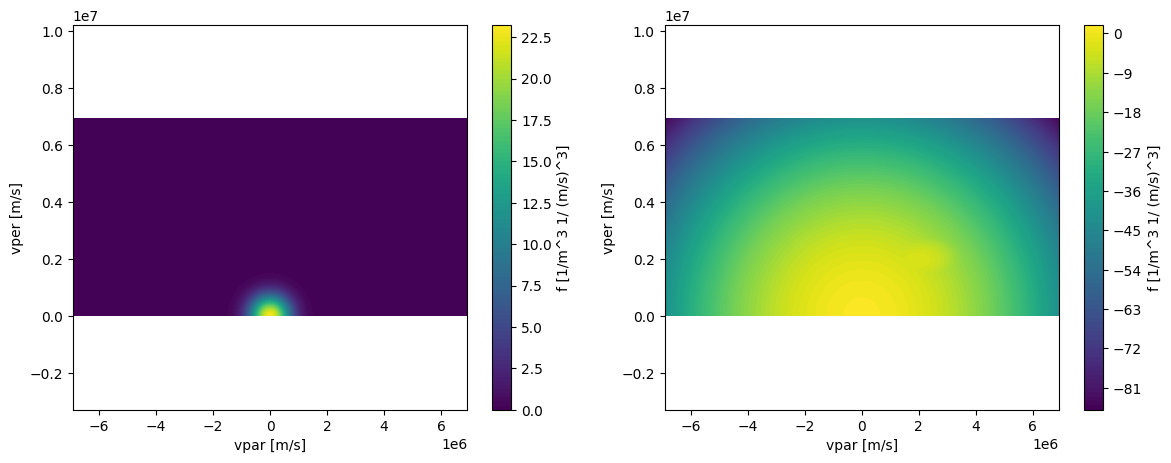

In [189]:
VPAR, VPER = np.meshgrid(vpar_array, vperp_array)
fig, ax = plt.subplots(1,2,figsize=(14,5))
cont = ax[0].contourf(VPAR, VPER, f_slice, levels=100, cmap="viridis")
ax[0].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[0])
cbar.set_label("f [1/m^3 1/ (m/s)^3]")  # optional label
ax[0].set_xlabel('vpar [m/s]')
ax[0].set_ylabel('vper [m/s]')

cont = ax[1].contourf(VPAR, VPER, np.log10(f_slice), levels=100, cmap="viridis")
ax[1].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[1])
cbar.set_label("f [1/m^3 1/ (m/s)^3]")  # optional label
ax[1].set_xlabel('vpar [m/s]')
ax[1].set_ylabel('vper [m/s]')

In [190]:
# sanity check
R, Z, vPer, vPar, f_saved = read_f_rzvv_nc(save_file)

print("Shapes:")
print("R:", R.shape)
print("Z:", Z.shape)
print("vPer:", vPer.shape)
print("vPar:", vPar.shape)
print("f_saved:", f_saved.shape)  # should be (nR, nZ, nVper, nVpar)


# Open the file in read-only mode
# with netCDF4.Dataset(save_file, "r") as nc:
#     # List all variables
#     print("Variables in file:", list(nc.variables.keys()))

#     # Read 1D coordinate variables
#     R = nc["R_binCenters"][:]
#     Z = nc["z_binCenters"][:]
#     vPer = nc["vPer_binCenters"][:]
#     vPar = nc["vPar_binCenters"][:]

#     print("R shape:", R.shape)
#     print("Z shape:", Z.shape)
#     print("vPer shape:", vPer.shape)
#     print("vPar shape:", vPar.shape)

#     # Read 4D distribution
#     f_rzvv = nc["f_rzvv"][:]
#     print("f_rzvv shape:", f_rzvv.shape)

#     # Example: check min, max, sum
#     print("f_rzvv min:", f_rzvv.min())
#     print("f_rzvv max:", f_rzvv.max())
#     print("f_rzvv sum:", f_rzvv.sum())
    
#     # Check a specific index (first element)
#     print("f_rzvv[0,0,0,0]:", f_rzvv[0,0,0,0])

Shapes:
R: (128,)
Z: (128,)
vPer: (65,)
vPar: (129,)
f_saved: (128, 128, 65, 129)


In [191]:
# testing out my numerical derivatives 
def deriv_dfdvperp(f_rzvv, vPer, i_r, i_z):
    """
    df/dvper with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvper slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvper_slice = np.zeros((n_vper, n_vpar))

    for ivpar in range(n_vpar):
        for ivper in range(n_vper):
            if 0 < ivper < n_vper-1:
                dfdvper_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper+1, ivpar] -
                    f_rzvv[i_r, i_z, ivper-1, ivpar]
                ) / (vPer[ivper+1] - vPer[ivper-1])

            elif ivper == 0 or ivper == n_vper-1:
                dfdvper_slice[ivper, ivpar] = 0.0

    return dfdvper_slice


def deriv_dfdvpar(f_rzvv, vPar, i_r, i_z):
    """
    df/dvpar with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
    i_r, i_z are indices in R,Z (Python 0-based).
    Returns dfdvpar slice of shape (n_vpar, n_vper).
    """
    n_r, n_z, n_vper, n_vpar = f_rzvv.shape
    dfdvpar_slice = np.zeros((n_vper, n_vpar))

    for ivper in range(n_vper):
        for ivpar in range(n_vpar):
            if 0 < ivpar < n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = (
                    f_rzvv[i_r, i_z, ivper, ivpar+1] -
                    f_rzvv[i_r, i_z, ivper, ivpar-1]
                ) / (vPar[ivpar+1] - vPar[ivpar-1])

            elif ivpar == 0 or ivpar == n_vpar-1:
                dfdvpar_slice[ivper, ivpar] = 0.0

    return dfdvpar_slice


In [192]:
# now, calculate the parallel derivative. R,Z doesnt matter

dfdvpar =  deriv_dfdvpar(f_rzvv=f_saved, vPar=vPar, i_r=0, i_z=0)
dfdvper =  deriv_dfdvperp(f_rzvv=f_saved, vPer=vPer, i_r=0, i_z=0)

In [193]:
print(dfdvpar)
print("df/dvper slice:", dfdvper.shape)  # (n_vpar, n_vper)
print("df/dvpar slice:", dfdvpar.shape)  # (n_vpar, n_vper)

print("Any NaNs in dfdvper?", np.isnan(dfdvper).any())
print("Any NaNs in dfdvpar?", np.isnan(dfdvpar).any())

[[ 0.  0.  0. ... -0. -0.  0.]
 [ 0.  0.  0. ... -0. -0.  0.]
 [ 0.  0.  0. ... -0. -0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
df/dvper slice: (65, 129)
df/dvpar slice: (65, 129)
Any NaNs in dfdvper? False
Any NaNs in dfdvpar? False


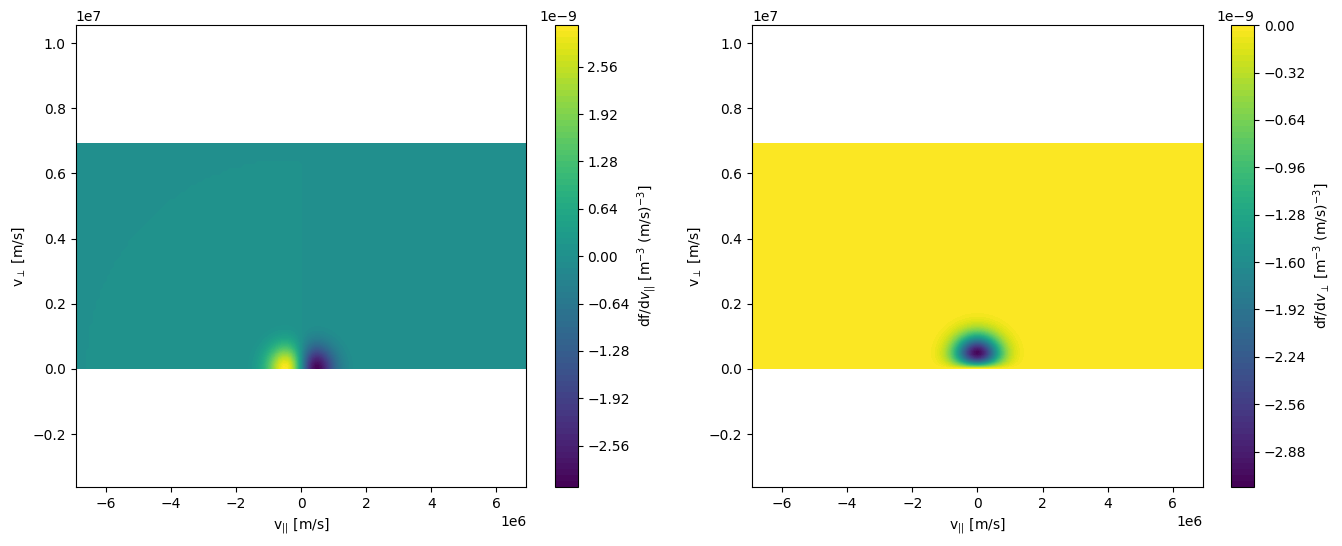

In [194]:
VPAR, VPER = np.meshgrid(vpar_array, vperp_array)
fig, ax = plt.subplots(1,2, figsize=(16,6))
cont = ax[0].contourf(VPAR, VPER, dfdvpar, levels=100, cmap="viridis")
ax[0].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[0])
cbar.set_label(r"df/d$v_{||}$ [m$^{-3}$ (m/s)$^{-3}$]")   # optional label
ax[0].set_xlabel(r'v$_{||}$ [m/s]')
ax[0].set_ylabel(r'v$_{\perp}$ [m/s]')

cont = ax[1].contourf(VPAR, VPER, dfdvper, levels=100, cmap="viridis")
ax[1].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[1])
cbar.set_label(r"df/d$v_{\perp}$ [m$^{-3}$ (m/s)$^{-3}$]")  # optional label
ax[1].set_xlabel(r'v$_{||}$ [m/s]')
ax[1].set_ylabel(r'v$_{\perp}$ [m/s]')

fac = 10
#ax[0].set_xlim(-vmax/fac, vmax/fac)

In [195]:
# try and compare to my cql3d file on perlmutter. 

import utils.CQL3D_Analysis as CQL
eqdsk_file = "/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/shots/147634/g147634.04525"
cql3d_nc_file = "/home/jacobvandelindt/aorsa_cql_mcgo_toolkit/aorsa_4df/cql3d.nc"
cql3d_krf_nc_file = None
cqlin_file = None#"
cql_pp = CQL.CQL3D_Post_Process(
    gen_species_names=["D", "e"],
    cql3d_nc_file=cql3d_nc_file,
    cql3d_krf_file=cql3d_krf_nc_file,
    eqdsk_file=eqdsk_file,
    cql_input_file=cqlin_file,
)

['   90   86\n']


In [170]:
# # testing out my numerical derivatives 
# def deriv_dfdvperp_CQL(f_rzvv, vPer):
#     """
#     df/dvper with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
#     i_r, i_z are indices in R,Z (Python 0-based).
#     Returns dfdvper slice of shape (n_vpar, n_vper).
#     """
#     n_vpar, n_vper = f_rzvv.shape
#     dfdvper_slice = np.zeros((n_vper, n_vpar))

#     for ivpar in range(n_vpar):
#         for ivper in range(n_vper):
#             if 0 < ivper < n_vper-1:
#                 dfdvper_slice[ivper, ivpar] = (
#                     f_rzvv[ivper+1, ivpar] -
#                     f_rzvv[ivper-1, ivpar]
#                 ) / (vPer[ivper+1] - vPer[ivper-1])

#             elif ivper == 0 or ivper == n_vper-1:
#                 dfdvper_slice[ivper, ivpar] = 0.0

#     return dfdvper_slice


# def deriv_dfdvpar_CQL(f_rzvv, vPar):
#     """
#     df/dvpar with f_rzvv shaped (n_vpar, n_vper, n_z, n_r).
#     i_r, i_z are indices in R,Z (Python 0-based).
#     Returns dfdvpar slice of shape (n_vpar, n_vper).
#     """
#     n_vpar, n_vper = f_rzvv.shape
#     dfdvpar_slice = np.zeros((n_vper, n_vpar))

#     for ivper in range(n_vper):
#         for ivpar in range(n_vpar):
#             if 0 < ivpar < n_vpar-1:
#                 dfdvpar_slice[ivper, ivpar] = (
#                     f_rzvv[ivper, ivpar+1] -
#                     f_rzvv[ivper, ivpar-1]
#                 ) / (vPar[ivpar+1] - vPar[ivpar-1])

#             elif ivpar == 0 or ivpar == n_vpar-1:
#                 dfdvpar_slice[ivper, ivpar] = 0.0

#     return dfdvpar_slice

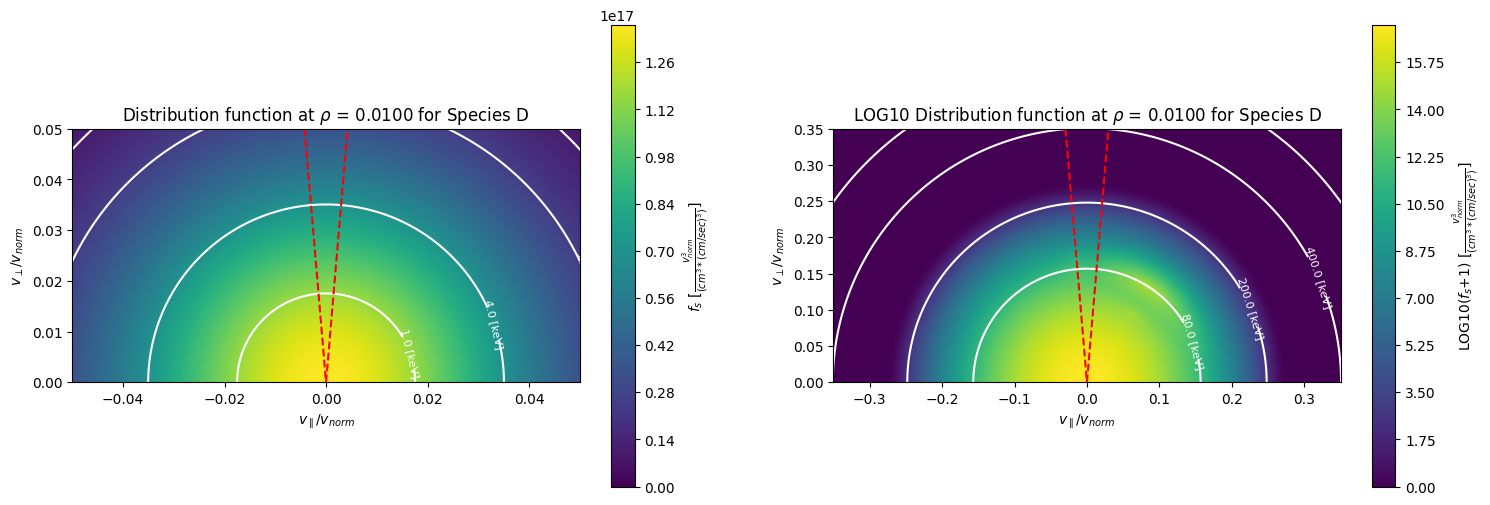

5.943312821792744e+19
cql vnorm:  17656190.750591323 m/s
your vnorm:  6922933.747058982 m/s


In [196]:
rho_index=0#2
cql_pp.plot_species_distribution_function_at_rho(
    gen_species_index=0,
    rho_index=rho_index,
    figsize=(18, 6),
    cmap="viridis",
    v_norm_over_v_max=0.05,
    log_scale_axis_multiple=7,
    energy_levels_linear=[1, 4, 10, 15, 20],
    energy_levels_log=[80, 200, 400, 600, 1000],
    energy_color="white",
    plot_trapped_passing=True,
)

print(cql_pp.integrate_distribution_function_over_velocity_space(gen_species_index=0, rho_index=rho_index))
f_s_rho, VPAR, VPERP = cql_pp.get_species_distribution_function_at_rho(
                gen_species_index=0, rho_index=rho_index
            )
print('cql vnorm: ', cql_pp.vnorm_cm_per_second/100, 'm/s')
print('your vnorm: ', vmax, 'm/s')

<a list of 3 text.Text objects>

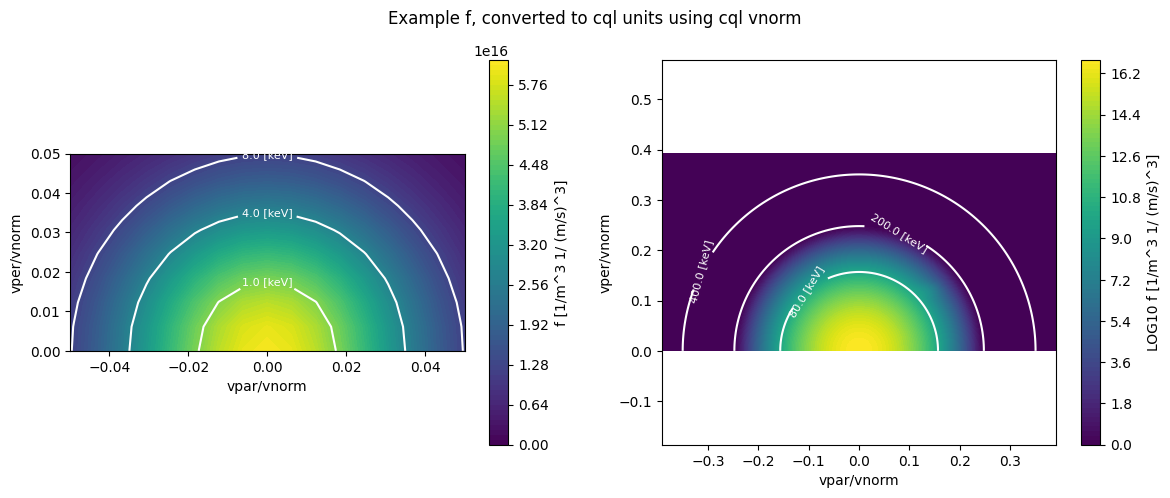

In [197]:
# comapre 
f_slice = f_mat[32,32,:,:]
vnorm_mks = cql_pp.vnorm_cm_per_second/100
factor = 1/(100)**6 * (cql_pp.vnorm_cm_per_second)**3
VPAR, VPER = np.meshgrid(vpar_array, vperp_array)
fig, ax = plt.subplots(1,2,figsize=(14,5))
cont = ax[0].contourf(VPAR/vnorm_mks, VPER/vnorm_mks, factor*f_slice, levels=100, cmap="viridis")

# Add colorbar
cbar = fig.colorbar(cont, ax=ax[0])
cbar.set_label("f [1/m^3 1/ (m/s)^3]")  # optional label
ax[0].set_xlabel('vpar/vnorm')
ax[0].set_ylabel('vper/vnorm')
ax[0].set_xlim(-0.05, 0.05)
ax[0].set_ylim(0, 0.05)
ax[0].set_aspect("equal")

cont = ax[1].contourf(VPAR/vnorm_mks, VPER/vnorm_mks, np.log10(factor*f_slice+1), levels=100, cmap="viridis")
ax[1].axis('equal')
# Add colorbar
cbar = fig.colorbar(cont, ax=ax[1])
cbar.set_label("LOG10 f [1/m^3 1/ (m/s)^3]")  # optional label
ax[1].set_xlabel('vpar/vnorm')
ax[1].set_ylabel('vper/vnorm')
fig.suptitle('Example f, converted to cql units using cql vnorm')

# energy levels 

energy_kev = 0.5*mass*(VPAR**2 + VPER**2)/kev_to_J
contour_lines1 = ax[0].contour(
    VPAR/vnorm_mks, VPER/vnorm_mks, energy_kev, levels=[1,4,8], colors='white'
)
ax[0].clabel(
    contour_lines1, inline=True, fontsize=8, fmt=lambda x: f"{x:.1f} [keV]"
)

contour_lines2 = ax[1].contour(
    VPAR/vnorm_mks, VPER/vnorm_mks, energy_kev, levels=[80,200,400], colors='white'
)
ax[1].clabel(
    contour_lines2, inline=True, fontsize=8, fmt=lambda x: f"{x:.1f} [keV]"
)


In [173]:
# calc derivatives 
print(f_s_rho.shape)
vcql = cql_pp.normalizedVel
thcql = cql_pp.pitchAngleMesh[rho_index,:]
vpar_cql = vcql*np.cos(0)

#dfdper, dfdpar = np.gradient(f_s_rho, VPERP[0,:], VPAR[:,0])

(500, 240)


In [174]:
print(np.sqrt(3.2e6/1000*kev_to_J*2/mass)/1e6)

17.513790984920313
